# Culstering in gender authorship

### I analyze Astronomical scientific literature to assess whether minorities have a propensity to clustering together in scientific projects. 

### This is an attempt to quanify, or at least justify, the assumption that having diversity in a department, particularly having diverse mentors, will foster diversity in recturing more junior scientists.

### An important assumption here is that among the first few authors one will be the mentor, grad advisor, or group leader, and that one will be a more junior scientist, grad student or postdoc. This is a common dynamic in authorship in astronomy 

### I analyze 5000 articles extracted from ADS in January 2015. 

### Of those I only consider papers with >= 3 authors. Where all three first names can be read (i.e. they are not initials) I cross check the first names against the list of first names and their usage derived from Social Security Administration records from 1960 to 2012.  I only keep a paper in the sample if all three first author genders can be identifies to at least 75% confidence level (where the ratio of gender usage for that first name is >0.75 for either males or females.) 

### From the original set of 5000 papers the final sample includes 1288 papers.

### Then I can check the distribution of ratios of femal authors (among the first 3 authors) against a randome distribution (given the number of papers, and the number of female authors collectively in the sample).

# The Null Hypothesis is that women authors are distributed at random among the papers. 
# The Alternative is that they are not.

### I can check this with a MC simulation, given the number of female authors in the sample and the number of papers, distributing the female authors among the papers 1000 times and checking whether the resulting distributions are consistent with the true one with  KS or anderson Darling test.



In [63]:
from __future__ import print_function, division
import os,sys
import pickle, pprint,csv
import numpy as np
import pylab as pl
%pylab inline

DEBUG = False
NMC = 1000 #number of montecarlo draws

# doing this only for >=3 author papers, 
# and limiting the inference to the first 3 authors
maxauth=3

#read in list of names
#    pkl_file = open('name_list/female.pkl', 'rb') 
#    femalenames = pickle.load(pkl_file)
#    pkl_file = open('name_list/male.pkl', 'rb') 
#    malenames = pickle.load(pkl_file)

femalenames = []
femalecounts = []

# reading in names with clear gender id

filename = 'namedb/female_uniq.csv'
with open(filename, 'rb') as f:
    reader = csv.reader(f)
    try:
        for row in reader:
            if row[0].startswith('#'):
                continue
            femalenames.append(row[0].lower())
            femalecounts.append(float(row[1].lower()))
    except csv.Error as e:
        sys.exit('file %s, line %d: %s' % (filename, reader.line_num, e))
femalenames = np.array(femalenames)
femalecounts = np.array(femalecounts)

malenames = []
malecounts = []

filename = 'namedb/male_uniq.csv'
with open(filename, 'rb') as f:
    reader = csv.reader(f)
    try:
        for row in reader:
            if row[0].startswith('#'):
                continue
            malenames.append(row[0].lower())
            malecounts.append(float(row[1].lower()))

    except csv.Error as e:
        sys.exit('file %s, line %d: %s' % (filename, reader.line_num, e))
malenames = np.array(malenames)
malecounts = np.array(malecounts)

if DEBUG: 
    print (femalecounts,malecounts)


Populating the interactive namespace from numpy and matplotlib


In [5]:
DEBUG = True

# reads in paper list
pkl_file = open('papers_recent.pkl', 'rb')
papers = pickle.load(pkl_file)

print ("We have a list of %d papers."%len(papers))
print ("\nThe first one looks like:")
print (papers[0])

We have a list of 5000 papers.

The first one looks like:
{'authors': [u'Ravignani, D.', u'Supanitsky, A. D.'], 'first_author_affiliation': u'ITeDA (CNEA, CONICET, UNSAM), Buenos Aires, Argentina', 'number_of_citations': 0, 'title': [u'A new method for reconstructing the muon lateral distribution with an array of segmented counters']}


In [6]:
DEBUG = False

def choosegender(first):
    nratio = femalecounts[femalenames == first] / malecounts[malenames == first]
    if nratio > 0.75:
        return 'f'
    if nratio < 0.25:
        return 'm'
    return 'u'

paperstats={'nauth':[],'ncite':[],'femaleratio':[]}

tot_female = 0
tot_male = 0
tot_unknowns = 0
for ppr in papers:
    femalecount = 0
    malecount = 0
    unknowns = 0
    # parse paper info
    try:
        ncite= ppr['number_of_citations']
    except:
        ncite=float('NaN')
            
    nauth = len(ppr['authors'])
    # skip if less than 3 authors
    if nauth < 3 : 
        continue
    # reduct to first 3 authors        
    authors=ppr['authors'][:maxauth]
                   
    for a in authors: 
        #read first name when possible
        try:
            first = a.split()[1].replace(',','').strip().lower()
        except:
            unknowns += 1
            continue
        if not '.' in first:
            if DEBUG:
                print ("nauth, ncite:", nauth, ncite,)
                print (first)
            if first in femalenames and first in malenames:
                #print (first)
                g = choosegender(first)
                if g == 'f':
                    femalecount += 1
                elif g == 'm':
                    malecount += 1
                else:
                    unknowns += 1
            elif first in femalenames : 
                femalecount += 1
            elif first in malenames : 
                malecount += 1
            else: 
                unknowns += 1
        else: 
            unknowns += 1
    if DEBUG:
        print ("females: ", femalecount)
        print ("males: ", malecount)
        print ("unknowns:", unknowns)
    
    if unknowns == 0:
        femaleratio = float(femalecount) / float(femalecount + malecount)
        #   print femaleratio, "maleratio:", float(malecount)/float(maxauth)
        tot_female += femalecount
        tot_male += malecount
        tot_unknowns += unknowns
        
        paperstats['nauth'].append(nauth)
        paperstats['ncite'].append(ncite)
        paperstats['femaleratio'].append(femaleratio)            
    # print femaleratio, "maleratio:", float(malecount)/float(maxauth)

    if DEBUG:
        print ("femaleratio:", femaleratio)    


(2721, 1143, 0)

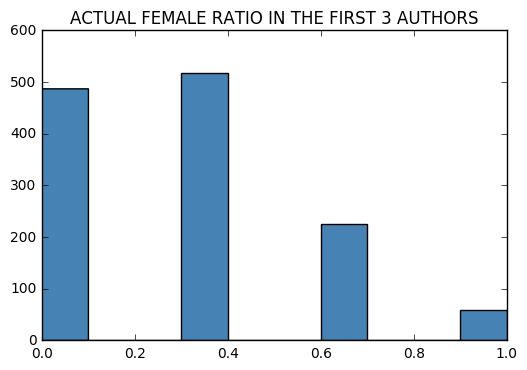

In [10]:
pl.figure()
pl.title("ACTUAL FEMALE RATIO IN THE FIRST 3 AUTHORS")
pl.hist(paperstats['femaleratio'], color='SteelBlue')    
tot_male, tot_female, tot_unknowns

1288 papers with the gender of all 3 authors identified


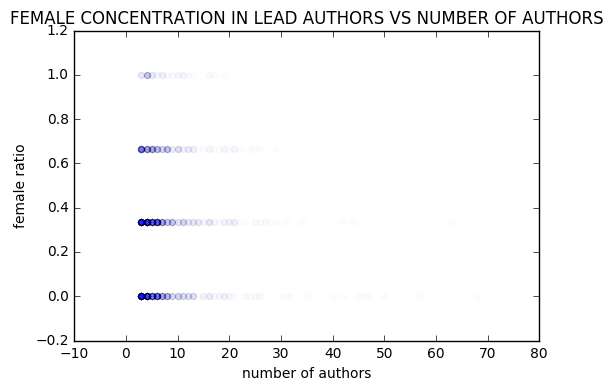

In [44]:
pl.figure()
pl.ylabel("female ratio")
pl.xlabel("number of authors")
pl.scatter(paperstats['nauth'], paperstats['femaleratio'], alpha = 0.01)
pl.title("FEMALE CONCENTRATION IN LEAD AUTHORS VS NUMBER OF AUTHORS")
Np = len(paperstats['ncite'])
print (Np, "papers with the gender of all 3 authors identified")
Nc = int(max(paperstats['ncite']) / 5) + 1

ncite = [None] * Nc
for i in range(Nc):
    ncite[i] = [paperstats['femaleratio'][ii] \
                for ii in range(len(paperstats['femaleratio'])) \
                if int(paperstats['ncite'][ii] / 5) == i]

#pl.figure()
#pl.title("FEMALE RATIO IN THE FIRST 3 AUTHORS AGAINST CITATION COUNT")
#for i in range(Nc):
#    pl.scatter([i * 5] * len(ncite[i]), ncite[i], alpha = 0.1)
#pl.ylabel("female ratio")
#pl.xlabel("citations")


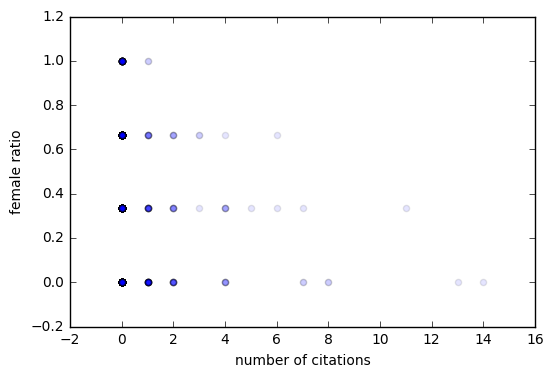

In [46]:
plt.figure()
plt.ylabel ("female ratio")
plt.xlabel ("number of citations")
plt.scatter(paperstats['ncite'], paperstats['femaleratio'], alpha = 0.1)
plt.show()
    

### MC Simulation

In [13]:
def pickAndDel(indx, picks):
    # print, indx, len(picks)
    tmp = picks[indx]
    del picks[indx]
    return tmp

fameleFracRand = np.zeros((1000, Np))

for i in range(NMC):
    picks = range(Np) + range(Np) + range(Np) 
    #femaleRand = randint(0, Np, tot_female)
    femaleRand = np.array([pickAndDel(randint(0, len(picks)), picks)  \
                  for j in range(tot_female)])
    fameleFracRand[i] = np.array([(femaleRand == j).sum() / \
                                  3.0 for j in range(Np)])


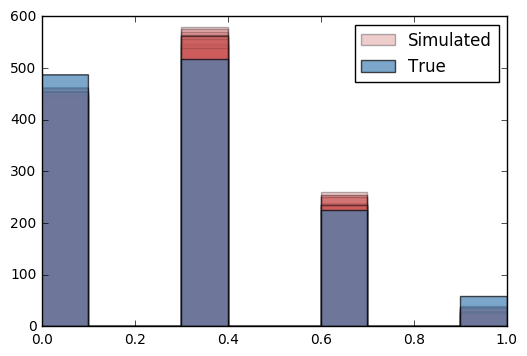

In [53]:
for i in range(10):
    pl.hist(fameleFracRand[i], color='IndianRed', alpha = 0.3)
pl.hist(fameleFracRand[i], color='IndianRed', alpha = 0.3, 
       label = "Simulated")
pl.hist(paperstats['femaleratio'], color='SteelBlue', alpha = 0.7, 
       label = "True") 
pl.legend()

In [28]:
ratios = np.zeros((1000,10))
for i in range(1000):
     ratios[i] = histogram(fameleFracRand[i])[0]

statratios = np.array([np.array([ratios[:,i].mean(), 
                                 ratios[:,i].std()]) for i in range(10)])
statratios.T

array([[ 449.687     ,    0.        ,    0.        ,  567.103     ,
           0.        ,    0.        ,  237.733     ,    0.        ,
           0.        ,   33.477     ],
       [   9.37128758,    0.        ,    0.        ,   16.99224503,
           0.        ,    0.        ,   10.16079283,    0.        ,
           0.        ,    5.09798696]])

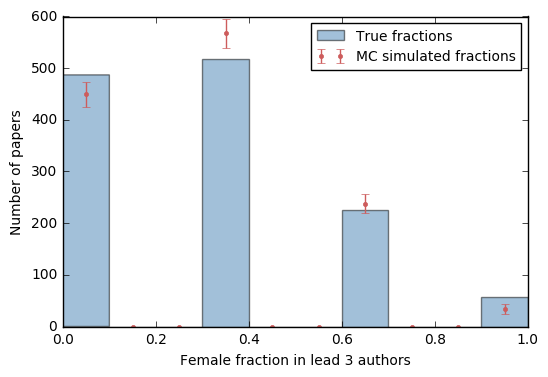

In [90]:
y = pl.hist(paperstats['femaleratio'], color='SteelBlue', alpha = 0.5, label="True fractions") 
x = 0.5 * (histogram(fameleFracRand[0])[1][1:] + 
           histogram(fameleFracRand[0])[1][:-1])
pl.errorbar(x, statratios[:, 0], 
            yerr = (statratios[:, 1]**2 + y[0])**0.5, 
            fmt = '.', color = 'IndianRed', label = "MC simulated fractions")
pl.legend(fontsize=10)
pl.xlabel("Female fraction in lead 3 authors")
pl.ylabel("Number of papers")

### MAIN FIGURE: The distribution of female authorship ratios is NOT consistent with random. Error bars include stochastic errors, obtained by MC simulations, and count statistics in the true distribution.

### statistical Tests (not great, cause they assume continuou data)

In [61]:
# KS test
sp.stats.ks_2samp(paperstats['femaleratio'], statratios[:, 0])

Ks_2sampResult(statistic=0.5953416149068324, pvalue=0.00086762636626221774)

In [62]:
# AD test
sp.stats.anderson_ksamp([paperstats['femaleratio'], statratios[:, 0]])

Anderson_ksampResult(statistic=9.1838890824470703, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.00020859034363768684)

# The Nnull hypothesis is that female authors are distributed randomely among papers is strongly rejected by both KS and AD tests to p<0.001!
# There is a significant excess of both papers with no and with all three female lead authors, and a deficit of papers with a single femal author compared to a randome gender distribution!

In [70]:
ks = np.zeros(NMC)
ad = np.zeros(NMC)
for i in range(NMC):
    ks[i] = sp.stats.ks_2samp(paperstats['femaleratio'], ratios[i])[1]
    ad[i] = sp.stats.anderson_ksamp([paperstats['femaleratio'], ratios[i]])[2]

In [82]:
print ("KS mean, std:", ks.mean(), ks.std())
print ("AD mean, std:", ad.mean(), ad.std())
if ks.mean() < 0.003 and ad.mean() < 0.003:
    print (r"Null Rejected at > 3 Sigma!")
else: 
    print ("Null not rejected")

KS mean, std: 0.000867626366262 1.08420217249e-19
AD mean, std: 0.000208590343638 2.71050543121e-20
Null Rejected at > 3 Sigma!
